In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

In [2]:
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

In [3]:
# Merge transactions with customers
merged_data = pd.merge(transactions, customers, on="CustomerID")

# Merge with products
merged_data = pd.merge(merged_data, products, on="ProductID")

In [4]:
customer_profiles = merged_data.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total spend
    "TransactionID": "count",  # Number of transactions
    "Quantity": "sum",  # Total quantity purchased
    "Region": "first",  # Region
    "Category": lambda x: x.mode()[0]  # Most purchased category
}).reset_index()


In [5]:
# One-hot encode categorical features
customer_profiles = pd.get_dummies(customer_profiles, columns=["Region", "Category"])

In [6]:
#Normalized features
scaler = MinMaxScaler()
customer_profiles_scaled = scaler.fit_transform(customer_profiles.drop("CustomerID", axis=1))

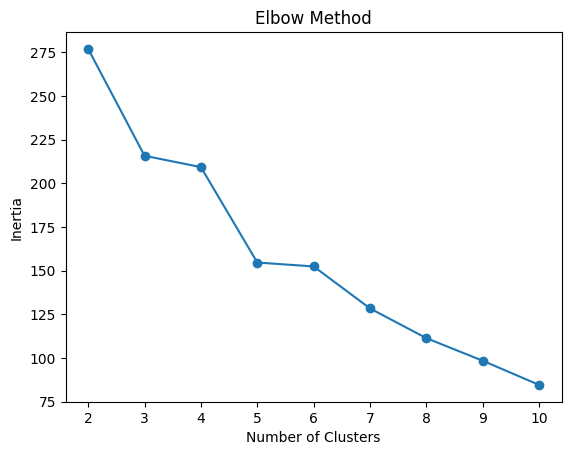

In [19]:
# Determine optimal number of clusters using the elbow method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_profiles_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.plot(range(2, 11), inertia, marker="o")
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [58]:
# Fit K-Means with k=4
kmeans = KMeans(n_clusters=10, random_state=42)
customer_profiles["Cluster"] = kmeans.fit_predict(customer_profiles_scaled)

In [59]:
# Calculate Davies-Bouldin Index (DB Index)
db_index = davies_bouldin_score(customer_profiles_scaled, customer_profiles["Cluster"])
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 0.9458067261778689


In [60]:
# Analyze cluster characteristics
cluster_summary = customer_profiles.groupby("Cluster").agg({
    "TotalValue": "mean",  # Average total spend
    "TransactionID": "mean",  # Average number of transactions
    "Quantity": "mean",  # Average quantity purchased
    "Region_North America": "mean",  # Percentage of customers in North America
    "Region_Europe": "mean",  # Percentage of customers in Europe
    "Category_Electronics": "mean",  # Percentage of customers who prefer Electronics
}).reset_index()

print(cluster_summary)

   Cluster   TotalValue  TransactionID   Quantity  Region_North America  \
0        0  3372.176471       4.823529  12.705882              0.000000   
1        1  3420.056765       4.823529  12.205882              0.264706   
2        2  3453.999231       5.076923  13.384615              0.000000   
3        3  3828.071739       5.869565  14.086957              1.000000   
4        4  2950.906970       4.696970  11.606061              0.424242   
5        5  3859.129167       5.500000  14.333333              0.000000   
6        6  4214.698095       5.619048  14.523810              0.000000   
7        7  3393.650000       5.461538  12.923077              0.000000   
8        8  3248.245000       4.428571  11.428571              0.000000   
9        9  3244.630000       4.263158  11.578947              0.000000   

   Region_Europe  Category_Electronics  
0       1.000000              0.000000  
1       0.264706              1.000000  
2       0.000000              0.000000  
3       0.

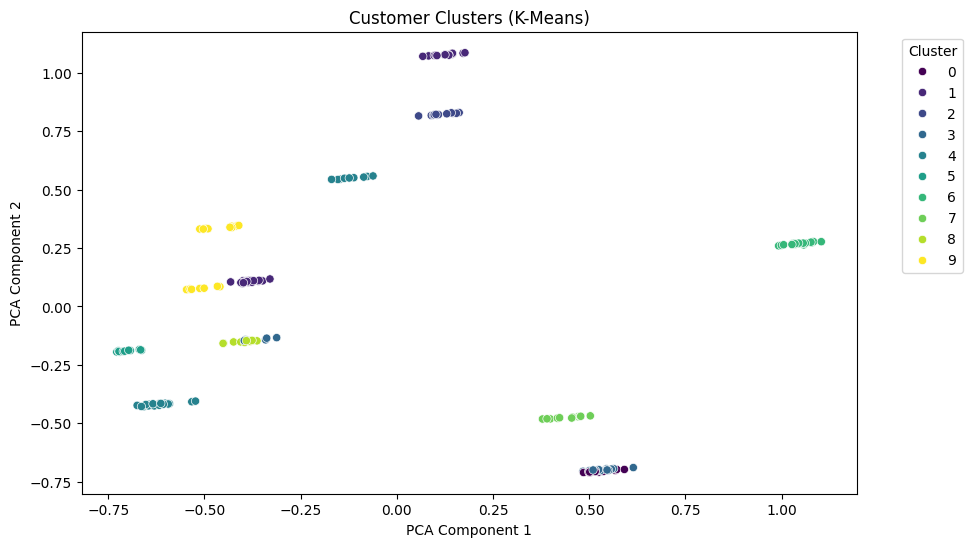

In [62]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
customer_profiles_pca = pca.fit_transform(customer_profiles_scaled)

# Add PCA components to the DataFrame
customer_profiles["PCA1"] = customer_profiles_pca[:, 0]
customer_profiles["PCA2"] = customer_profiles_pca[:, 1]

# Plot clusters with legends
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PCA1", y="PCA2",
    hue="Cluster",
    palette="viridis",
    data=customer_profiles,
    legend="full"
)
plt.title("Customer Clusters (K-Means)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()